## Introduction

Your goal is to assess the trade-offs of stability, accuracy, and run-time of a least two methods applied to two ODE systems. 

The first ODE system is two proteins degrading. The ODEs are:

\begin{eqnarray*}
\frac{dy_1}{dt}&=&-\alpha y_1\\
\frac{dy_2}{dt}&=&-\beta y_2\\
\end{eqnarray*}

where $\alpha=0.1$ and $\beta=0.2$.

The second ODE system is the Lotka-Volterra model of predator-prey populations and their interactions. You can check out the Wikipedia entry to learn more, but what you need to know here is that it is a 2-ODE system and that, with the right parameter values, it leads to oscillations. The ODEs are:

\begin{align*}
\frac{dx}{dt} &= \alpha x -\beta x y\\
\frac{dy}{dt} &= -\gamma y + \delta x y\\
\end{align*}

where $\alpha=0.25$, $\beta=0.01$, $\gamma=1$, and $\delta=0.01$.


## The Project

Consider three methods -- the forward Euler method, the explicit trapezoidal method, and an adaptive step-size forward Euler method (that uses the trapezoidal method to estimate the local error).

Compare the performance of each of your three methods on the degradation and predator-prey systems.  In your analysis, you will want to consider both efficiency (how long does it take the method to run?) and accuracy (how close is the method to the "true" solution?). For the first two methods, be sure to consider the effect of step-size on accuracy and speed. For the third, be sure to analyze the step-sizes chosen and the effect of error tolerance on the step size. 


## Extensions

This project will be more interesting if you tackle one or more of these extensions.  Feel free to develop your own extension. And, as always, a particularly thorough analysis is smiled upon.

<ul>
<li> Analyze the van der Pol oscillator in addition to the models above. The equations for it are:
\begin{align*}
\frac{dy_1}{dt} &= y_2\\
\frac{dy_2}{dt} &= \mu (1-y_1^2)y_2 - y_1.\\
\end{align*}
When $\mu=50$, the period of oscillation is long (nearly 80) and the system is stiff. When $\mu=1$, the period is short (approximately 6) and the system is not stiff. We expect implicit methods to perform better on the stiff system. Demonstrate that it is better to use the implicit method when $\mu=50$, but that explicit methods are perfectly adequate when $\mu=1$.
<li> Implement additional explicit Runge-Kutta methods. In particular, it would be nice to see the results of a fourth order method.
<li> Implement Adams-Bashforth method (this should be covered in Lecture 15).
<li> Implement the Backward Euler method and compare its results to those of your other methods. (Note that backward euler is an implicit method, which means the solution at the new time step appears on both sides of the equation and, therefore, requires additional computation. For example, you will need to use Newton's method to approximately solve a nonlinear system of algebraic equations. If you chose to use Backward Euler, consult Stephanie before writing code.)

</ul>

## Notes

### Timing
To time your method, use the <a href="https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit">%timeit</a> magic command. You use it either for a single line of code, e.g.   

<code>
%timeit (t,y) = forwardEuler( models.protein_degradation, np.arange(0,50,0.01), np.array([1,1]), params)
</code>

or to time an entire cell, e.g.
<code>
%%timeit
(t,y) = forwardEuler( models.protein_degradation, np.arange(0,50,0.01), np.array([1,1]), params)   
</code>

If you use it in cell mode, then be sure to put just the solving code in the cell. Put any plotting code in a different cell, because you don't want to include that.

### Accuracy
To compute the accuracy of your method, compare its output to the output of scipy.integrate.solve_ivp (which will stand in for the "true solution"). Set its relative tolerance so that it is "tight" (i.e. you will tolerate very little error; rtol=1e-8).  Error calculations should be performed by comparing the solutions to $y$ at the same time steps, but you will likely be comparing the true solution to outputs from methods using lots of different time steps. The easiest way to handle this is to call scipy.integrate.solve_ivp for each unique set of timesteps you have. For example, when you use the adaptive step size function, you do not know ahead of time which timesteps you will have, so run that first, and use the output to set the t_eval parameter for solve_ivp:
<code>
(t,y,steps) = forwardEulerAdaptiveStepSize( models.protein_degradation, 0, 50, 
    np.array([1,1]), params, 1e-4)
sol = scipy.integrate.solve_ivp(fun=models.protein_degradation, t_span=(0,50), y0=(1,1), 
                                method='LSODA', t_eval=t, args=[params], rtol=1e-8, atol=1e-8 )
</code>
    
To compute the error, use one of the methods we described in Lecture 11 (first, compute the error at each time point, then summarize it over time).

<hr style="border:2px solid gray"> </hr>

Begin your code and report here. Organize your report in the manner that best allows you to answer all the questions. Integrate your extensions with your main project.


In [3]:
# Start code and write-up here.
import numpy as np
#start by creating the degradation and predator-prey ode functions
def degradation_model(t, y, params):
    y1=y[0]
    y2=y[1]
    dydt=np.zeros((2,))
    dydt[0]=-params[0]*y1
    dydt[1]=-params[1]*y2
    return dydt

def predator_prey_model(t, y, params):
    x = y[0]
    y = y[1]
    dydt = np.zeros((2,))
    dydt[0] = (params[0]*x) - (params[1]*x*y) #dxdt
    dydt[1] = (-params[2]*y) + (params[3]*x*y) #dydt
    return dydt

#then we will create the forward euler method, the explicit trapezoidal method, then the adaptive step-size forward euler method
def forwardEuler( fn, t, y0, params ):
    y = np.zeros( (y0.size,t.size) )
    y[:,0] = y0
    for i in range(1,t.size):
        h = t[i]-t[i-1]
        yprime = fn(t[i-1],y[:,i-1],params)
        y[:,i] = y[:,i-1] + h*yprime
    return (t,y)

def explicit_trapezoidal(fn, t, y0, params):
    y = np.zeros( (y0.size,t.size) )
    y[:,0] = y0
    for i in range(1,t.size):
        h = t[i] - t[i-1]
        yprime = fn(t[i-1],y[:,i-1],params)
        yhatFE = y[:,i-1] + h*yprime
        yprimeFE = fn(t[i], yhatFE, params)
        y[:,i] = y[:,i-1] + h * ( ( yprimeFE + yprime )/2 )
    return (t,y)

def forwardEulerAdaptiveStepSize(f,t0,tFinal,y0,params,ETOL):
    y=[np.array(y0)]
    t = [t0]
    steps = []
    h = (1/100) * tFinal-t0
    while t[-1] < tFinal:
        YFE = y[-1] + h*f(t[0],y[-1],params)
        YET = y[-1] + h*((f(t[-1],y[-1],params) + f(t[-1] + h,YFE,params))/2)
        err = np.linalg.norm(YET-YFE,2)
        if err <= ETOL:
            y.append(YFE)
            t.append(t[-1]+h)
            steps.append(h)
        hnew = h * np.sqrt(0.9*(ETOL/err))
        if hnew > 2*h:
            hnew = 2*h
        h = hnew
    t = np.array(t)
    y = np.array(y).T
    steps = np.array(steps)
    return (t,y,steps)

#true method gets to be scipy.integrate.solve_ivp, with rtol=1e-8


In [5]:
#set all the terms for odes degradation and predator-prey
paramsDegrad = np.array([0.1,0.2])
paramsPP = np.array([0.25,0.01,1,0.01])

In [4]:
%%timeit
#this cell will look at time and run the forward euler on degradation
(t1,y1) = forwardEuler(degradation_model, np.arange(0,50,0.01), np.array([1,1]), paramsDegrad)

31.1 ms ± 993 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


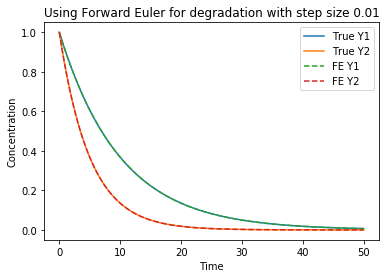

In [5]:
import scipy.integrate
import matplotlib.pyplot as plt
#plot the forward euler on degradation
#comparing to scipy.integrate.solve_ivp
(t1,y1) = forwardEuler(degradation_model, np.arange(0,50,0.01), np.array([1,1]), paramsDegrad)
dm = lambda t,y: degradation_model(t, y, paramsDegrad)
sol = scipy.integrate.solve_ivp(fun=dm,t_span=(0,50), y0=np.array([1,1]), method="LSODA", t_eval=np.arange(0,50,0.01), rtol=1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Forward Euler for degradation with step size 0.01")
plt.legend(["True Y1", "True Y2", "FE Y1", "FE Y2"]);

In [6]:
%%timeit
#degradation with expicit trapezoidal

(t1,y1) = explicit_trapezoidal(degradation_model, np.arange(0,50,0.01), np.array([1,1]), paramsDegrad)

66.4 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


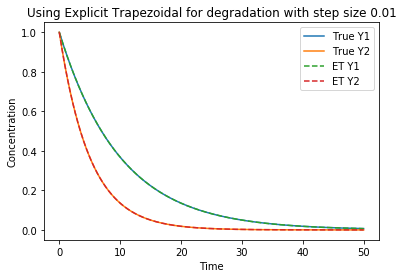

In [7]:
import scipy.integrate
import matplotlib.pyplot as plt
#comparing to scipy.integrate.solve_ivp
(t1,y1) = explicit_trapezoidal(degradation_model, np.arange(0,50,0.01), np.array([1,1]), paramsDegrad)
dm = lambda t,y: degradation_model(t, y, paramsDegrad)
sol = scipy.integrate.solve_ivp(fun=dm,t_span=(0,50), y0=np.array([1,1]), t_eval=np.arange(0,50,0.01), method="LSODA", rtol= 1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Explicit Trapezoidal for degradation with step size 0.01")
plt.legend(["True Y1", "True Y2", "ET Y1", "ET Y2"]);

## Stuff about cell above accuracy and time

In [8]:
%%timeit
#now we change the step size
(t1,y1) = forwardEuler(degradation_model, np.arange(0,50,0.1), np.array([1,1]), paramsDegrad)

3.06 ms ± 81.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


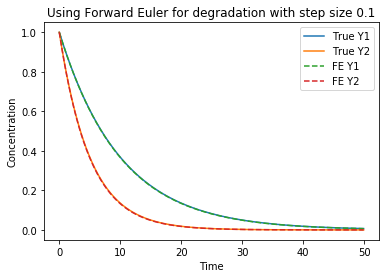

In [9]:
import scipy.integrate
import matplotlib.pyplot as plt
#plot the forward euler on degradation
#comparing to scipy.integrate.solve_ivp
(t1,y1) = forwardEuler(degradation_model, np.arange(0,50,0.1), np.array([1,1]), paramsDegrad)
dm = lambda t,y: degradation_model(t, y, paramsDegrad)
sol = scipy.integrate.solve_ivp(fun=dm,t_span=(0,50), y0=np.array([1,1]), t_eval=np.arange(0,50,0.1), method="LSODA", rtol= 1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Forward Euler for degradation with step size 0.1")
plt.legend(["True Y1", "True Y2", "FE Y1", "FE Y2"]);

In [10]:
%%timeit
#degradation with expicit trapezoidal

(t1,y1) = explicit_trapezoidal(degradation_model, np.arange(0,50,0.1), np.array([1,1]), paramsDegrad)

6.47 ms ± 211 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


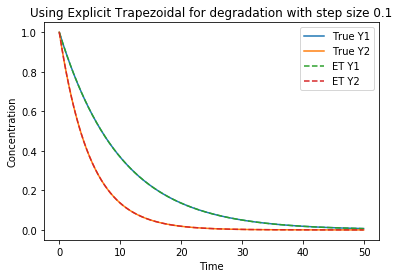

In [11]:
import scipy.integrate
import matplotlib.pyplot as plt
#comparing to scipy.integrate.solve_ivp
(t1,y1) = explicit_trapezoidal(degradation_model, np.arange(0,50,0.1), np.array([1,1]), paramsDegrad)
dm = lambda t,y: degradation_model(t, y, paramsDegrad)
sol = scipy.integrate.solve_ivp(fun=dm,t_span=(0,50), y0=np.array([1,1]), t_eval=np.arange(0,50,0.1), method="LSODA", rtol= 1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Explicit Trapezoidal for degradation with step size 0.1")
plt.legend(["True Y1", "True Y2", "ET Y1", "ET Y2"]);

## Stuff about this second graph with 0.1 step sizes

In [12]:
%%timeit
(t1,y1) = forwardEuler(degradation_model, np.arange(0,50,1), np.array([1,1]), paramsDegrad)

307 µs ± 7.46 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


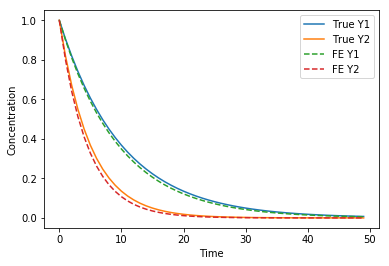

In [13]:
import scipy.integrate
import matplotlib.pyplot as plt
#plot the forward euler on degradation
#comparing to scipy.integrate.solve_ivp
(t1,y1) = forwardEuler(degradation_model, np.arange(0,50,1), np.array([1,1]), paramsDegrad)
dm = lambda t,y: degradation_model(t, y, paramsDegrad)
sol = scipy.integrate.solve_ivp(fun=dm,t_span=(0,50), y0=np.array([1,1]), t_eval=np.arange(0,50,1), method="LSODA", rtol= 1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.legend(["True Y1", "True Y2", "FE Y1", "FE Y2"]);

In [14]:
%%timeit

(t1,y1) = explicit_trapezoidal(degradation_model, np.arange(0,50,1), np.array([1,1]), paramsDegrad)

676 µs ± 35.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


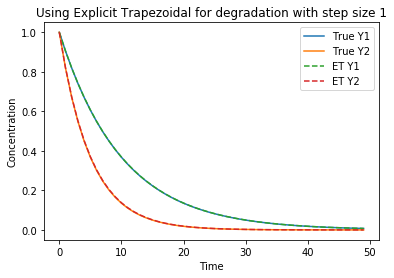

In [15]:
import scipy.integrate
import matplotlib.pyplot as plt
#comparing to scipy.integrate.solve_ivp
(t1,y1) = explicit_trapezoidal(degradation_model, np.arange(0,50,1), np.array([1,1]), paramsDegrad)
dm = lambda t,y: degradation_model(t, y, paramsDegrad)
sol = scipy.integrate.solve_ivp(fun=dm,t_span=(0,50), y0=np.array([1,1]), t_eval=np.arange(0,50,1), method="LSODA", rtol= 1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Explicit Trapezoidal for degradation with step size 1")
plt.legend(["True Y1", "True Y2", "ET Y1", "ET Y2"]);

## Stuff about this difference when we use a time step of 1 from 0 to 50

In [16]:
%%timeit
#now we change the step size one last time
(t1,y1) = forwardEuler(degradation_model, np.arange(0,50,5), np.array([1,1]), paramsDegrad)

62.1 µs ± 2.28 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


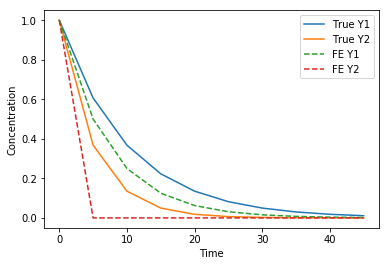

In [17]:
import scipy.integrate
import matplotlib.pyplot as plt
#plot the forward euler on degradation
#comparing to scipy.integrate.solve_ivp
(t1,y1) = forwardEuler(degradation_model, np.arange(0,50,5), np.array([1,1]), paramsDegrad)
dm = lambda t,y: degradation_model(t, y, paramsDegrad)
sol = scipy.integrate.solve_ivp(fun=dm,t_span=(0,50), y0=np.array([1,1]), t_eval=np.arange(0,50,5), method="LSODA", rtol= 1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.legend(["True Y1", "True Y2", "FE Y1", "FE Y2"]);

In [18]:
%%timeit

(t1,y1) = explicit_trapezoidal(degradation_model, np.arange(0,50,5), np.array([1,1]), paramsDegrad)

124 µs ± 1.79 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


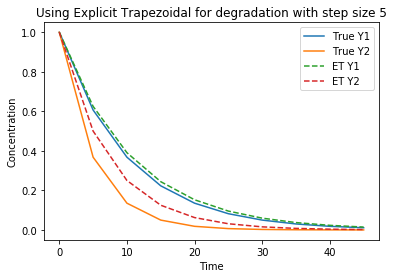

In [19]:
import scipy.integrate
import matplotlib.pyplot as plt
#comparing to scipy.integrate.solve_ivp
(t1,y1) = explicit_trapezoidal(degradation_model, np.arange(0,50,5), np.array([1,1]), paramsDegrad)
dm = lambda t,y: degradation_model(t, y, paramsDegrad)
sol = scipy.integrate.solve_ivp(fun=dm,t_span=(0,50), y0=np.array([1,1]), t_eval=np.arange(0,50,5), method="LSODA", rtol= 1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Explicit Trapezoidal for degradation with step size 5")
plt.legend(["True Y1", "True Y2", "ET Y1", "ET Y2"]);

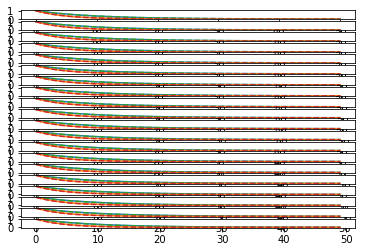

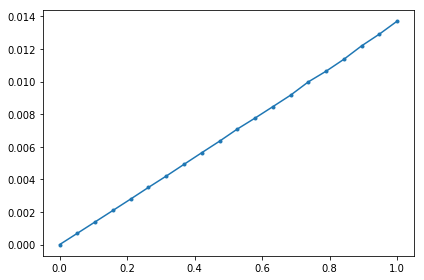

In [20]:
#plot errors for foward Euler and degradation
dts = np.linspace(1e-4,1,20)
err = np.zeros( (dts.size,) )
y0 = np.array([1,1])

for i in range(dts.size):
    t = np.arange(0,50,dts[i])
    (t1,y1) = forwardEuler( degradation_model, t, y0, paramsDegrad)
    sol = scipy.integrate.solve_ivp(fun=degradation_model, t_span=(0,50), y0=y0, method='LSODA', rtol=1e-8, atol=1e-8, t_eval=t, args=[paramsDegrad] )
    plt.subplot( dts.size, 1, i+1 )
    plt.plot( t1, sol.y.T )
    plt.plot( t1, y1.T, '--')
    err[i] = np.mean(scipy.linalg.norm( sol.y-y1, np.inf, axis=0) )
    
plt.figure()
# plt.subplot(2,1,1)
plt.plot( dts, err, '.-' )
# plt.subplot(2,1,2)
# plt.plot( dts, err2, '.-' )
plt.tight_layout()

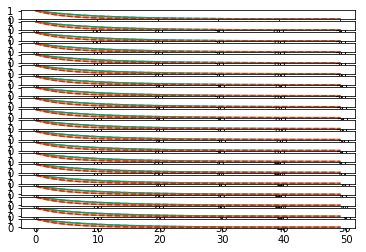

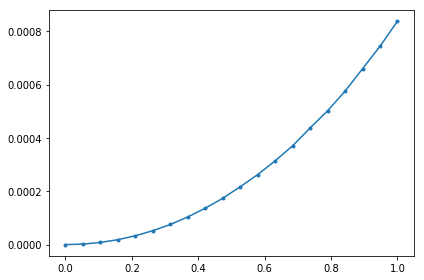

In [21]:
#explicit trapzoidal error for degradation
dts = np.linspace(1e-4,1,20)
err = np.zeros( (dts.size,) )
y0 = np.array([1,1])

for i in range(dts.size):
    t = np.arange(0,50,dts[i])
    (t1,y1) = explicit_trapezoidal( degradation_model, t, y0, paramsDegrad)
    sol = scipy.integrate.solve_ivp(fun=degradation_model, t_span=(0,50), y0=y0, method='LSODA', rtol=1e-8, atol=1e-8, t_eval=t, args=[paramsDegrad] )
    plt.subplot( dts.size, 1, i+1 )
    plt.plot( t1, sol.y.T )
    plt.plot( t1, y1.T, '--')
    err[i] = np.mean(scipy.linalg.norm( sol.y-y1, np.inf, axis=0) )
    
plt.figure()
# plt.subplot(2,1,1)
plt.plot( dts, err, '.-' )
# plt.subplot(2,1,2)
# plt.plot( dts, err2, '.-' )
plt.tight_layout()

## Stuff about when we use time step of 5 from 0 to 50

In [22]:
%%timeit
#this cell will look at time and run the forward euler on degradation
(t1,y1) = forwardEuler(predator_prey_model, np.arange(0,50,0.01), np.array([1,1]), paramsPP)

34.4 ms ± 740 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


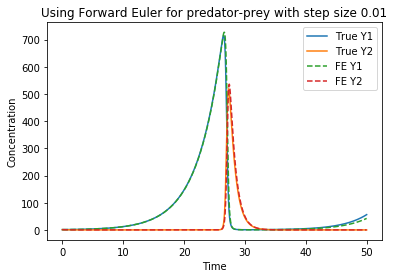

In [23]:
import scipy.integrate
import matplotlib.pyplot as plt
#plot the forward euler on degradation
#comparing to scipy.integrate.solve_ivp
(t1,y1) = forwardEuler(predator_prey_model, np.arange(0,50,0.01), np.array([1,1]), paramsPP)
pp = lambda t,y: predator_prey_model(t, y, paramsPP)
sol = scipy.integrate.solve_ivp(fun=pp,t_span=(0,50), y0=np.array([1,1]), t_eval=np.arange(0,50,0.01), method="LSODA", rtol= 1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Forward Euler for predator-prey with step size 0.01")
plt.legend(["True Y1", "True Y2", "FE Y1", "FE Y2"]);

In [24]:
%%timeit
(t1,y1) = explicit_trapezoidal(predator_prey_model, np.arange(0,50,0.01), np.array([1,1]), paramsPP)

72.2 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


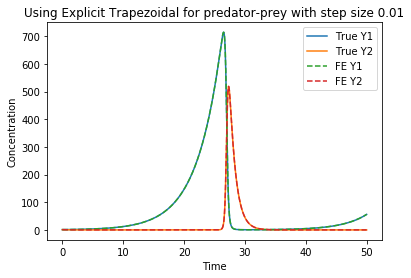

In [25]:
import scipy.integrate
import matplotlib.pyplot as plt
(t1,y1) = explicit_trapezoidal(predator_prey_model, np.arange(0,50,0.01), np.array([1,1]), paramsPP)
pp = lambda t,y: predator_prey_model(t, y, paramsPP)
sol = scipy.integrate.solve_ivp(fun=pp,t_span=(0,50), y0=np.array([1,1]), t_eval=np.arange(0,50,0.01), method="LSODA", rtol= 1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Explicit Trapezoidal for predator-prey with step size 0.01")
plt.legend(["True Y1", "True Y2", "FE Y1", "FE Y2"]);

## Looking at the predator prey now, time goes up again with 0.01 time step, and the lines seem pretty accurate


In [26]:
%%timeit
#this cell will look at time and run the forward euler on degradation
(t1,y1) = forwardEuler(predator_prey_model, np.arange(0,50,0.1), np.array([1,1]), paramsPP)

3.54 ms ± 248 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


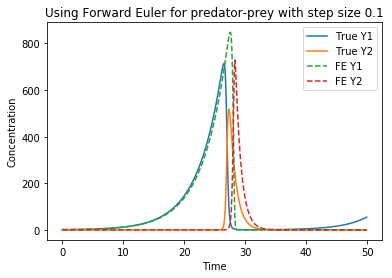

In [27]:
import scipy.integrate
import matplotlib.pyplot as plt
(t1,y1) = forwardEuler(predator_prey_model, np.arange(0,50,0.1), np.array([1,1]), paramsPP)
pp = lambda t,y: predator_prey_model(t, y, paramsPP)
sol = scipy.integrate.solve_ivp(fun=pp,t_span=(0,50), y0=np.array([1,1]), t_eval=np.arange(0,50,0.1), method="LSODA", rtol= 1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Forward Euler for predator-prey with step size 0.1")
plt.legend(["True Y1", "True Y2", "FE Y1", "FE Y2"]);

In [28]:
%%timeit
(t1,y1) = explicit_trapezoidal(predator_prey_model, np.arange(0,50,0.1), np.array([1,1]), paramsPP)

7.37 ms ± 244 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


[[1.00000000e+00 1.00000000e+00]
 [1.02433869e+00 9.05911312e-01]
 [1.04936355e+00 8.20695449e-01]
 [1.07508682e+00 7.43514302e-01]
 [1.10152142e+00 6.73609017e-01]
 [1.12868097e+00 6.10292497e-01]
 [1.15657976e+00 5.52942611e-01]
 [1.18523273e+00 5.00996047e-01]
 [1.21465550e+00 4.53942747e-01]
 [1.24486432e+00 4.11320865e-01]
 [1.27587612e+00 3.72712210e-01]
 [1.30770845e+00 3.37738112e-01]
 [1.34037952e+00 3.06055685e-01]
 [1.37390819e+00 2.77354443e-01]
 [1.40831397e+00 2.51353232e-01]
 [1.44361701e+00 2.27797459e-01]
 [1.47983813e+00 2.06456576e-01]
 [1.51699883e+00 1.87121812e-01]
 [1.55512125e+00 1.69604107e-01]
 [1.59422824e+00 1.53732254e-01]
 [1.63434331e+00 1.39351206e-01]
 [1.67549068e+00 1.26320553e-01]
 [1.71769527e+00 1.14513135e-01]
 [1.76098273e+00 1.03813792e-01]
 [1.80537944e+00 9.41182279e-02]
 [1.85091250e+00 8.53319850e-02]
 [1.89760978e+00 7.73695149e-02]
 [1.94549993e+00 7.01533357e-02]
 [1.99461236e+00 6.36132710e-02]
 [2.04497731e+00 5.76857592e-02]
 [2.096625

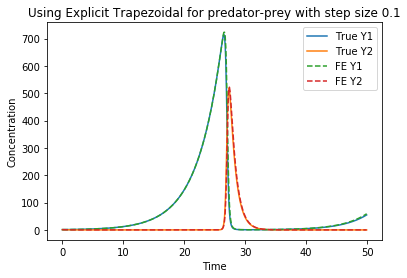

In [38]:
import scipy.integrate
import matplotlib.pyplot as plt
(t1,y1) = explicit_trapezoidal(predator_prey_model, np.arange(0,50,0.1), np.array([1,1]), paramsPP)
pp = lambda t,y: predator_prey_model(t, y, paramsPP)
sol = scipy.integrate.solve_ivp(fun=pp,t_span=(0,50), y0=np.array([1,1]), t_eval=np.arange(0,50,0.1), method="LSODA", rtol= 1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
#print(y1.T)
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Explicit Trapezoidal for predator-prey with step size 0.1")
plt.legend(["True Y1", "True Y2", "FE Y1", "FE Y2"]);

## Starts to diverge

In [30]:
%%timeit
#this cell will look at time and run the forward euler on degradation
(t1,y1) = forwardEuler(predator_prey_model, np.arange(0,50,1), np.array([1,1]), paramsPP)

353 µs ± 10 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


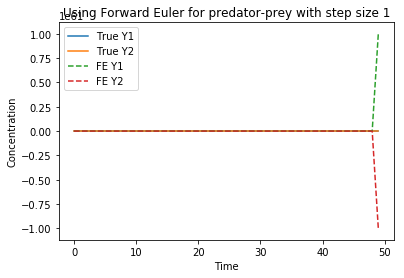

In [7]:
import scipy.integrate
import matplotlib.pyplot as plt
#plot the forward euler on degradation
#comparing to scipy.integrate.solve_ivp
(t1,y1) = forwardEuler(predator_prey_model, np.arange(0,50,1), np.array([1,1]), paramsPP)
pp = lambda t,y: predator_prey_model(t, y, paramsPP)
sol = scipy.integrate.solve_ivp(fun=pp,t_span=(0,50), y0=np.array([1,1]), t_eval=np.arange(0,50,1), method="LSODA", rtol= 1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
#print(y1.T)
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Forward Euler for predator-prey with step size 1")
plt.legend(["True Y1", "True Y2", "FE Y1", "FE Y2"]);

In [32]:
%%timeit
(t1,y1) = explicit_trapezoidal(predator_prey_model, np.arange(0,50,1), np.array([1,1]), paramsPP)

750 µs ± 11 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


[[ 1.00000000e+000  1.00000000e+000]
 [ 1.27493800e+000  5.00062000e-001]
 [ 1.62947904e+000  2.50081599e-001]
 [ 2.08518171e+000  1.25082217e-001]
 [ 2.66997499e+000  6.25750657e-002]
 [ 3.41983337e+000  3.13153991e-002]
 [ 4.38096929e+000  1.56805839e-002]
 [ 5.61266875e+000  7.85909933e-003]
 [ 7.19094067e+000  3.94502230e-003]
 [ 9.21320268e+000  1.98526048e-003]
 [ 1.18042911e+001  1.00316226e-003]
 [ 1.51241652e+001  5.10317431e-004]
 [ 1.93777811e+001  2.62454323e-004]
 [ 2.48277441e+001  1.37386597e-004]
 [ 3.18105206e+001  7.39862565e-005]
 [ 4.07572101e+001  4.16723364e-005]
 [ 5.22201605e+001  2.51626673e-005]
 [ 6.69070681e+001  1.68699087e-005]
 [ 8.57246692e+001  1.31548966e-005]
 [ 1.09834719e+002  1.26194250e-005]
 [ 1.40725716e+002  1.58244943e-005]
 [ 1.80304790e+002  2.74987425e-005]
 [ 2.31015425e+002  6.96230526e-005]
 [ 2.95988181e+002  2.67039641e-004]
 [ 3.79232901e+002  1.59570899e-003]
 [ 4.85874029e+002  1.51408606e-002]
 [ 6.22256751e+002  2.30940686e-001]
 

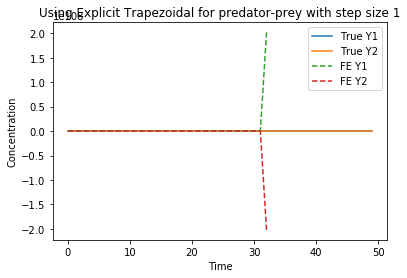

In [40]:
import scipy.integrate
import matplotlib.pyplot as plt
(t1,y1) = explicit_trapezoidal(predator_prey_model, np.arange(0,50,1), np.array([1,1]), paramsPP)
pp = lambda t,y: predator_prey_model(t, y, paramsPP)
sol = scipy.integrate.solve_ivp(fun=pp,t_span=(0,50), y0=np.array([1,1]), t_eval=np.arange(0,50,1), method="LSODA", rtol= 1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
print(y1.T)
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Explicit Trapezoidal for predator-prey with step size 1")
plt.legend(["True Y1", "True Y2", "FE Y1", "FE Y2"]);

Works at: 0.2425
Breaks at: 0.2526


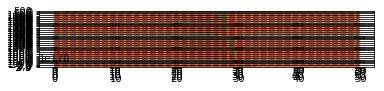

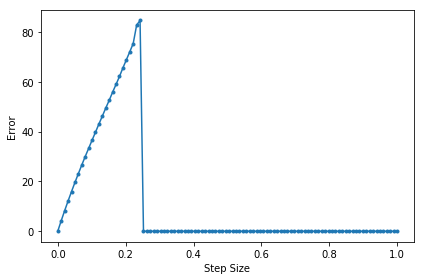

In [13]:
#plot errors

## weird behavior
dts = np.linspace(1e-4,1,100)
err = np.zeros( (dts.size,) )
y0 = np.array([1,1])

for i in range(dts.size):
    try:
        t = np.arange(0,50,dts[i])
        (t1,y1) = forwardEuler( predator_prey_model, t, y0, paramsPP)
        sol = scipy.integrate.solve_ivp(fun=predator_prey_model, t_span=(0,50), y0=y0, method='LSODA', rtol=1e-8, atol=1e-8, t_eval=t, args=[paramsPP] )
        plt.subplot( dts.size, 1, i+1 )
        plt.plot( t1, sol.y.T )
        plt.plot( t1, y1.T, '--')
        #print(y1.T)
        err[i] = np.mean(scipy.linalg.norm( sol.y-y1, np.inf, axis=0) )
    except:
        print("Works at:", dts[i-1])
        print("Breaks at:", dts[i])
        break
    
plt.figure()
# plt.subplot(2,1,1)
plt.plot( dts, err, '.-' )
# plt.subplot(2,1,2)
# plt.plot( dts, err2, '.-' )
plt.ylabel("Error")
plt.xlabel("Step Size")
plt.tight_layout()

## Completely breaks because it misses the spike, so the comparison really doesn't work

In [148]:
%%timeit
#degradation with adaptive step size forward euler

(t1,y1, steps) = forwardEulerAdaptiveStepSize(degradation_model, 0, 50, np.array([1,1]), paramsDegrad, 1e-4)

#time = %timeit -o forwardEulerAdaptiveStepSize(degradation_model, 0, 50, np.array([1,1]), paramsDegrad, 1e-4)
#time.best


4.9 ms ± 469 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


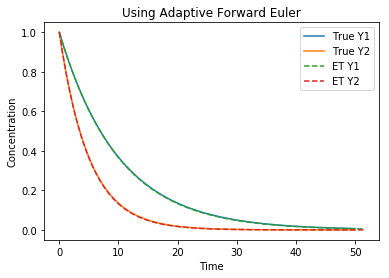

In [118]:
import scipy.integrate
import matplotlib.pyplot as plt
#plot the forward euler on degradation
#comparing to scipy.integrate.solve_ivp
(t1,y1, steps) = forwardEulerAdaptiveStepSize(degradation_model, 0, 50, np.array([1,1]), paramsDegrad, 1e-4)
dm = lambda t,y: degradation_model(t, y, paramsDegrad)
sol = scipy.integrate.solve_ivp(fun=dm,t_span=(0,50), y0=np.array([1,1]), t_eval=t, method="LSODA", rtol= 1e-8, atol=1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Adaptive Forward Euler")
plt.legend(["True Y1", "True Y2", "ET Y1", "ET Y2"]);

## Very accurate, next cell looks at errors

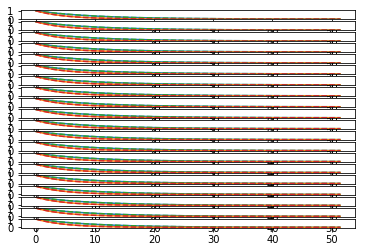

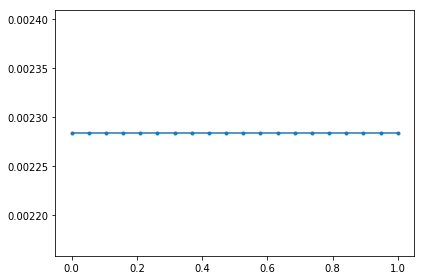

In [160]:
dts = np.linspace(1e-4,1,20)
err = np.zeros( (dts.size,) )
y0 = np.array([1,1])

for i in range(dts.size):
    #t = np.arange(0,50,dts[i])
    (t,y, steps) = forwardEulerAdaptiveStepSize( degradation_model, 0, 50, y0, paramsDegrad, 1e-4)
    sol = scipy.integrate.solve_ivp(fun=degradation_model, t_span=(0,60), y0=y0, method='LSODA', rtol=1e-8, atol=1e-8, t_eval=t, args=[paramsDegrad] )
    plt.subplot( dts.size, 1, i+1 )
    plt.plot( t, sol.y.T )
    plt.plot( t, y.T, '--')
    err[i] = np.mean(scipy.linalg.norm( sol.y-y, np.inf, axis=0) )
    
plt.figure()
# plt.subplot(2,1,1)
plt.plot( dts, err, '.-' )
# plt.subplot(2,1,2)
# plt.plot( dts, err2, '.-' )
plt.tight_layout()

In [120]:
%%timeit
(t1,y1, steps) = forwardEulerAdaptiveStepSize(predator_prey_model, 0, 50, np.array([1,1]), paramsPP, 1e-4)

358 ms ± 14.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


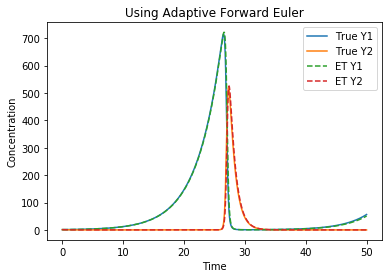

In [119]:
import scipy.integrate
import matplotlib.pyplot as plt
#plot the adaptive on predator-prey
#comparing to scipy.integrate.solve_ivp
(t1,y1, steps) = forwardEulerAdaptiveStepSize(predator_prey_model, 0, 50, np.array([1,1]), paramsPP, 1e-4)
pp = lambda t,y: predator_prey_model(t, y, paramsPP)
sol = scipy.integrate.solve_ivp(fun=pp,t_span=(0,50), y0=np.array([1,1]), t_eval=t, method="LSODA", rtol= 1e-8, atol=1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Adaptive Forward Euler")
plt.legend(["True Y1", "True Y2", "ET Y1", "ET Y2"]);

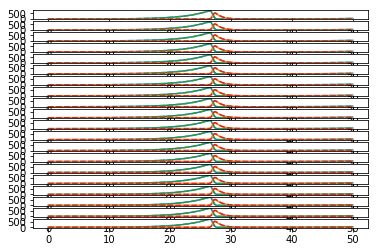

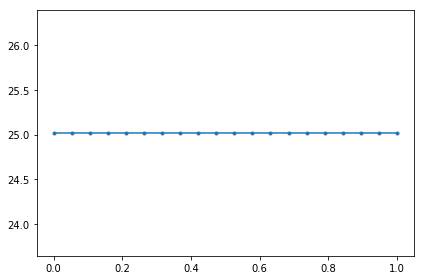

In [159]:
#plot errors
dts = np.linspace(1e-4,1,20)
err = np.zeros( (dts.size,) )
y0 = np.array([1,1])

for i in range(dts.size):
    #t = np.arange(0,50,dts[i])
    (t,y, steps) = forwardEulerAdaptiveStepSize( predator_prey_model, 0, 50, y0, paramsPP, 1e-4)
    sol = scipy.integrate.solve_ivp(fun=predator_prey_model, t_span=(0,60), y0=y0, method='LSODA', rtol=1e-8, atol=1e-8, t_eval=t, args=[paramsPP] )
    plt.subplot( dts.size, 1, i+1 )
    plt.plot( t, sol.y.T )
    plt.plot( t, y.T, '--')
    err[i] = np.mean(scipy.linalg.norm( sol.y-y, np.inf, axis=0) )
    
plt.figure()
# plt.subplot(2,1,1)
plt.plot( dts, err, '.-' )
# plt.subplot(2,1,2)
# plt.plot( dts, err2, '.-' )
plt.tight_layout()

## See the accuracy of adaptive step size

<hr style="border:2px solid gray"> </hr>

Acknowledgements

*Replace this text with links to external resources and thanks to people you worked with.*